<a href="https://colab.research.google.com/github/bianglalametro/decision-tree-crop-yield/blob/main/Decision_Tree_kelayakan_panen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import pandas as pd
from sklearn.metrics import accuracy_score
import networkx as nx
import matplotlib.pyplot as plt
import random

In [ ]:
df = pd.read_csv('dataset.csv')

df.head()

,plant_age_days,height_cm,leaf_color,rainfall,soil_moisture,ready
0,64,58,dark_green,medium,high,no
1,76,113,yellow,low,medium,yes
2,85,50,light_green,medium,high,no
3,118,133,green,medium,high,yes
4,46,139,dark_green,high,medium,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   plant_age_days  500 non-null    int64 
 1   height_cm       500 non-null    int64 
 2   leaf_color      500 non-null    object
 3   rainfall        500 non-null    object
 4   soil_moisture   500 non-null    object
 5   ready           500 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.6+ KB


In [ ]:
df.describe()

,plant_age_days,height_cm
count,500.000000,500.00000
mean,73.880000,75.62400
std,26.481922,35.64435
min,30.000000,15.00000
25%,50.000000,43.75000
50%,75.000000,75.00000
75%,96.250000,107.00000
max,119.000000,139.00000


In [ ]:
dataset = df.to_dict('records')
def stratified_train_test_split(data, test_size=0.2, random_seed=42):
    random.seed(random_seed)
    class_groups = {}
    for row in data:
        label = row["ready"]
        if label not in class_groups:
            class_groups[label] = []
        class_groups[label].append(row)

    train_data = []
    test_data = []

    for label, rows in class_groups. items():
        random.shuffle(rows)
        split_idx = int(len(rows) * (1 - test_size))
        train_data.extend(rows[:split_idx])
        test_data.extend(rows[split_idx:])

    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data, test_data

train_data, test_data = stratified_train_test_split(dataset, test_size=0.2, random_seed=42)

print(f"Total data: {len(dataset)}")
print(f"Training set: {len(train_data)}")
print(f"Test set: {len(test_data)}")

Total data: 500
Training set: 399
Test set: 101


In [ ]:
def calculate_entropy(data):
    if not data:
        return 0
    counts = {}
    for row in data:
        label = row["ready"]
        counts[label] = counts.get(label, 0) + 1
    entropy = 0
    total = len(data)
    for label in counts:
        prob = counts[label] / total
        entropy -= prob * math.log2(prob)
    return entropy

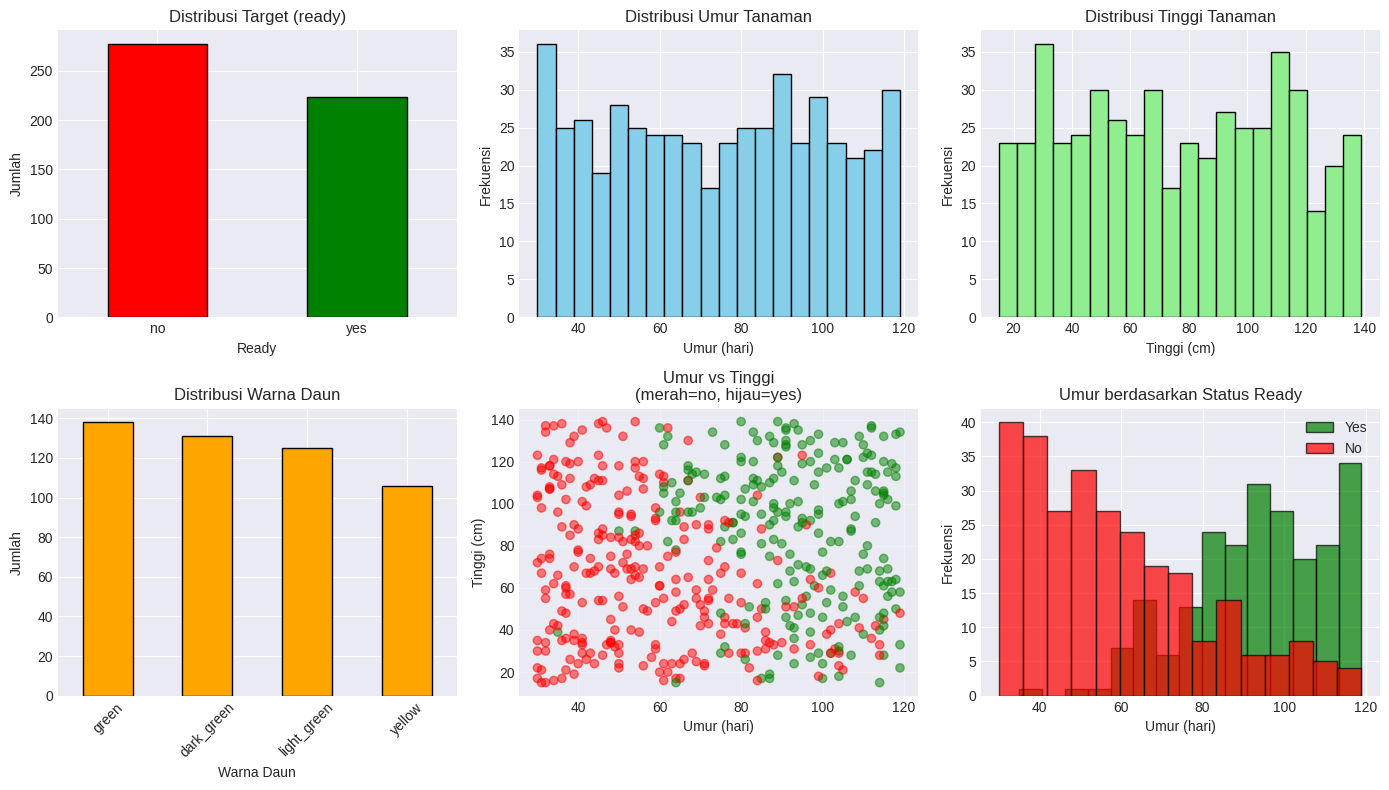

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

df['ready'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['red', 'green'], edgecolor='black')
axes[0, 0].set_title('Distribusi Target (ready)')
axes[0, 0].set_xlabel('Ready')
axes[0, 0].set_ylabel('Jumlah')
axes[0, 0].tick_params(axis='x', rotation=0)

df['plant_age_days'].hist(bins=20, ax=axes[0, 1], edgecolor='black', color='skyblue')
axes[0, 1].set_title('Distribusi Umur Tanaman')
axes[0, 1].set_xlabel('Umur (hari)')
axes[0, 1].set_ylabel('Frekuensi')

df['height_cm'].hist(bins=20, ax=axes[0, 2], edgecolor='black', color='lightgreen')
axes[0, 2].set_title('Distribusi Tinggi Tanaman')
axes[0, 2].set_xlabel('Tinggi (cm)')
axes[0, 2].set_ylabel('Frekuensi')

df['leaf_color'].value_counts().plot(kind='bar', ax=axes[1, 0], edgecolor='black', color='orange')
axes[1, 0].set_title('Distribusi Warna Daun')
axes[1, 0].set_xlabel('Warna Daun')
axes[1, 0].set_ylabel('Jumlah')
axes[1, 0].tick_params(axis='x', rotation=45)

colors = ['red' if x == 'no' else 'green' for x in df['ready']]
axes[1, 1].scatter(df['plant_age_days'], df['height_cm'], c=colors, alpha=0.5)
axes[1, 1].set_title('Umur vs Tinggi\n(merah=no, hijau=yes)')
axes[1, 1].set_xlabel('Umur (hari)')
axes[1, 1].set_ylabel('Tinggi (cm)')
axes[1, 1].grid(True, alpha=0.3)

df[df['ready']=='yes']['plant_age_days'].hist(bins=15, alpha=0.7, label='Yes', color='green', ax=axes[1, 2], edgecolor='black')
df[df['ready']=='no']['plant_age_days'].hist(bins=15, alpha=0.7, label='No', color='red', ax=axes[1, 2], edgecolor='black')
axes[1, 2].set_title('Umur berdasarkan Status Ready')
axes[1, 2].set_xlabel('Umur (hari)')
axes[1, 2].set_ylabel('Frekuensi')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('eda_simple.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def split_data(data, attribute, value, is_numeric):
    true_rows = []
    false_rows = []
    for row in data:
        if is_numeric:
            if row[attribute] >= value:
                true_rows. append(row)
            else:
                false_rows.append(row)
        else:
            if row[attribute] == value:
                true_rows.append(row)
            else:
                false_rows.append(row)
    return true_rows, false_rows

In [ ]:
def find_best_split(data):
    best_gain = 0
    best_question = None
    current_entropy = calculate_entropy(data)

    if not data:
        return 0, None

    attributes = [k for k in data[0].keys() if k != "ready"]

    for attribute in attributes:
        unique_values = set(row[attribute] for row in data)
        is_numeric = isinstance(list(unique_values)[0], (int, float))

        for val in unique_values:
            true_rows, false_rows = split_data(data, attribute, val, is_numeric)
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            p = len(true_rows) / len(data)
            gain = current_entropy - (p * calculate_entropy(true_rows) + (1 - p) * calculate_entropy(false_rows))

            if gain >= best_gain:
                best_gain = gain
                best_question = (attribute, val, is_numeric)

    return best_gain, best_question

In [ ]:
class Node:
    def __init__(self, question=None, true_branch=None, false_branch=None, prediction=None):
        self.question = question
        self.true_branch = true_branch
        self. false_branch = false_branch
        self.prediction = prediction

In [ ]:
def build_tree(data, depth=0, max_depth=10, min_samples_split=2):
    labels = [row["ready"] for row in data]

    # Stopping criteria - UPDATED with min_samples_split check
    if (labels.count(labels[0]) == len(labels) or
        depth >= max_depth or
        len(data) < min_samples_split):  # <- Added this condition
        return Node(prediction=max(set(labels), key=labels.count))

    gain, question = find_best_split(data)

    if gain == 0 or question is None:
        return Node(prediction=max(set(labels), key=labels.count))

    attribute, val, is_numeric = question
    true_rows, false_rows = split_data(data, attribute, val, is_numeric)

    true_branch = build_tree(true_rows, depth + 1, max_depth, min_samples_split)
    false_branch = build_tree(false_rows, depth + 1, max_depth, min_samples_split)

    return Node(question=question, true_branch=true_branch, false_branch=false_branch)

In [ ]:
def predict_row(node, row):
    if node. prediction is not None:
        return node.prediction
    attribute, value, is_numeric = node.question

    val_to_check = row. get(attribute)
    if is_numeric:
        match = val_to_check >= value
    else:
        match = val_to_check == value

    if match:
        return predict_row(node.true_branch, row)
    else:
        return predict_row(node. false_branch, row)

In [ ]:
initial_entropy = calculate_entropy(train_data)

features_gain = []

for attribute in ['plant_age_days', 'height_cm', 'leaf_color', 'rainfall', 'soil_moisture']:
    unique_values = set(row[attribute] for row in train_data)
    is_numeric = isinstance(list(unique_values)[0], (int, float))

    best_gain = 0
    best_threshold = None

    for val in unique_values:
        true_rows, false_rows = split_data(train_data, attribute, val, is_numeric)

        if len(true_rows) == 0 or len(false_rows) == 0:
            continue

        p = len(true_rows) / len(train_data)
        gain = initial_entropy - (p * calculate_entropy(true_rows) +
                                 (1 - p) * calculate_entropy(false_rows))

        if gain > best_gain:
            best_gain = gain
            best_threshold = val

    features_gain.append((attribute, best_gain, best_threshold, is_numeric))

features_gain.sort(key=lambda x: x[1], reverse=True)

print("Information Gain")
for attr, gain, threshold, is_num in features_gain:
    op = ">=" if is_num else "=="

    print(f"{attr:20s}: {gain:.4f}  (split: {op} {threshold})")

Information Gain
plant_age_days      : 0.3534  (split: >= 60)
height_cm           : 0.0641  (split: >= 76)
soil_moisture       : 0.0161  (split: == medium)
rainfall            : 0.0097  (split: == high)
leaf_color          : 0.0096  (split: == light_green)


In [ ]:
my_tree = build_tree(train_data, max_depth=3, min_samples_split=20)
y_train = [row["ready"] for row in train_data]
y_pred_train = [predict_row(my_tree, row) for row in train_data]

y_test = [row["ready"] for row in test_data]
y_pred_test = [predict_row(my_tree, row) for row in test_data]

def calculate_accuracy(y_true, y_pred):
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    return correct / len(y_true)

In [ ]:
acc_train = calculate_accuracy(y_train, y_pred_train)
acc_test = calculate_accuracy(y_test, y_pred_test)

print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")

Train Accuracy: 0.8672
Test Accuracy: 0.8713


In [ ]:
def add_nodes_edges(node, graph=None, pos=None, x=0, y=0, layer=1):
    if graph is None:
        graph = nx.DiGraph()
    if pos is None:
        pos = {}
    node_id = id(node)

    if node. prediction is not None:
        label = f"Predict:\n{node.prediction}"
        graph.add_node(node_id, label=label, shape='s')
    else:
        attribute, value, is_numeric = node.question
        op = ">=" if is_numeric else "=="
        label = f"{attribute}\n{op} {value}?"
        graph.add_node(node_id, label=label, shape='o')

        dx = 1 / (2 ** layer)
        graph.add_edge(node_id, id(node. true_branch), label="True")
        add_nodes_edges(node.true_branch, graph, pos, x - dx, y - 1, layer + 1)

        graph.add_edge(node_id, id(node.false_branch), label="False")
        add_nodes_edges(node.false_branch, graph, pos, x + dx, y - 1, layer + 1)

    pos[node_id] = (x, y)
    return graph, pos

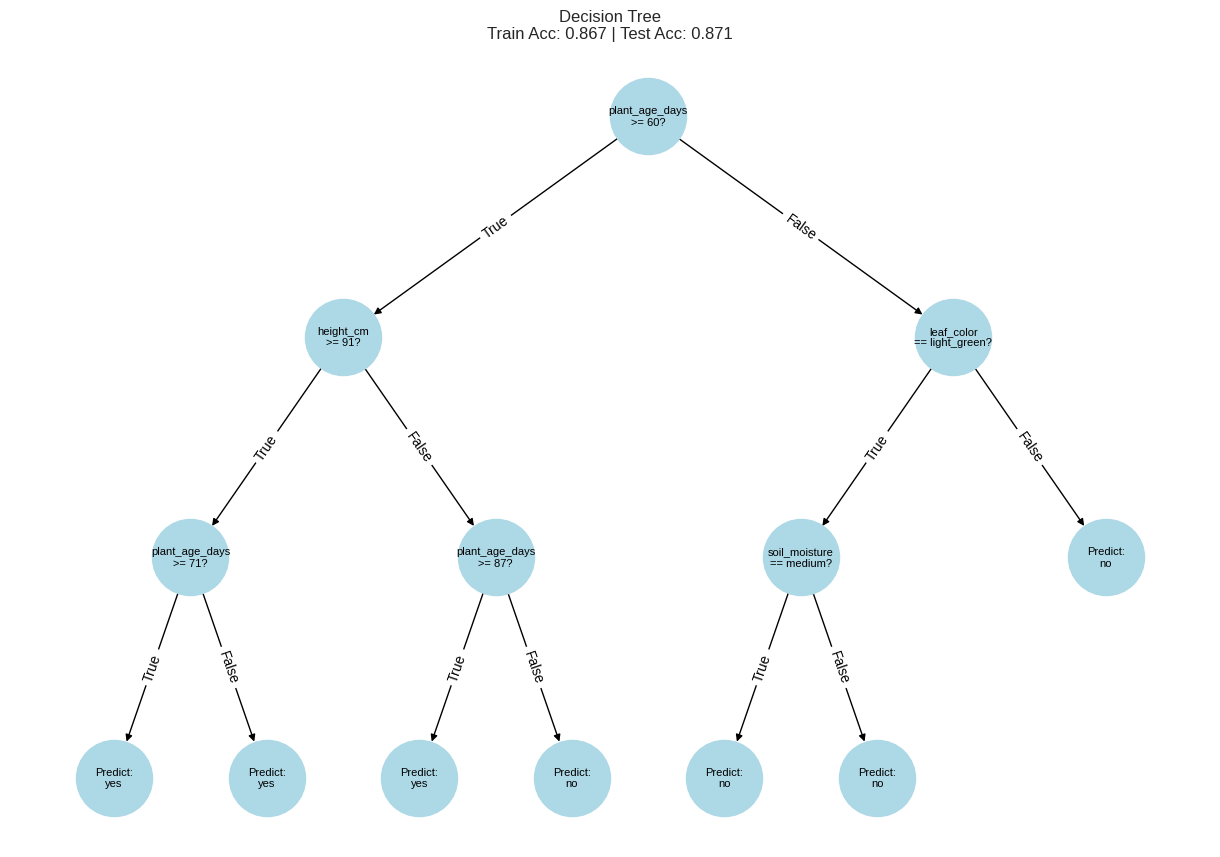

In [ ]:
graph, pos = add_nodes_edges(my_tree)
plt.figure(figsize=(12, 8))
labels = nx.get_node_attributes(graph, 'label')
nx. draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=8)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'label'))
plt.title(f"Decision Tree\nTrain Acc: {acc_train:.3f} | Test Acc: {acc_test:.3f}")
plt. show()

In [ ]:
def print_tree_rules(node, depth=0, prefix="Root"):
    indent = "  " * depth

    if node. prediction is not None:
        print(f"{indent}→ ready = {node.prediction}")
        return

    attribute, value, is_numeric = node.question

    if is_numeric:
        op = f">= {value}"
    else:
        op = f'== "{value}"'

    if depth == 0:
        print(f"Root: {attribute} ({op})")
    else:
        print(f"{indent}Branch: {attribute} {op}")

    if node.true_branch. prediction is not None:
        print(f"{indent}  IF True → ready = {node. true_branch.prediction}")
    else:
        print(f"{indent}  IF True:")
        print_tree_rules(node. true_branch, depth + 1, "Branch")

    if node.false_branch.prediction is not None:
        print(f"{indent}  IF False → ready = {node.false_branch.prediction}")
    else:
        print(f"{indent}  IF False:")
        print_tree_rules(node.false_branch, depth + 1, "Branch")

print_tree_rules(my_tree)


Root: plant_age_days (>= 60)
  IF True:
  Branch: height_cm >= 91
    IF True:
    Branch: plant_age_days >= 71
      IF True → ready = yes
      IF False → ready = yes
    IF False:
    Branch: plant_age_days >= 87
      IF True → ready = yes
      IF False → ready = no
  IF False:
  Branch: leaf_color == "light_green"
    IF True:
    Branch: soil_moisture == "medium"
      IF True → ready = no
      IF False → ready = no
    IF False → ready = no
